---
---
# **Phase 2: Architectures**
*IS53051A/IS71071B: MACHINE LEARNING*

by Augusta Lina

---

<center>
  <figure>
    <img src="https://i.imgur.com/0Sl1wst.png" >
   </figcaption>
  </figure>
</center>

---
---
# Introduction
---

In Phase 2 we iteratively increase the model's architectural complexity to improve the model's ability to capture information. We test a deeper model architecture to reduce underfitting, batch norm and spatial dropout, depthwise separable convolutions and a U-Net architecture. The results showed that all the architecture adjustments, except for depthwise separable convolutions, improved the model's performance. The process was performed iteratively, after each round, the model was evaluated on the validation set and if performance improved, the architecture was carried through to the next round.

<center>
  <figure>
    <img src="https://i.imgur.com/JeIBmmZ.png" >
   </figcaption>
  </figure>
</center>

The results of Phase 2 are shown in the table below. We can see that the model improved its performance each round, with the inclusion of depthwise separable convolutions significantly decreasing performance and the U-Net model performing best across all metrics. The plot also includes the best performing model from Phase 1, which is shown in blue. We can see that the architecture changes significantly improve the performance compared to the baseline model.


<center>
  <figure>
    <img src="https://i.imgur.com/bUImyhJ.png" >
   </figcaption>
  </figure>
</center>

---
---
# Set up Environment
----

We mount Google Drive and change the working directory.

In [ ]:
# Import libraries
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory & Confirm
WORKING_DIR = '/content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory'
os.chdir(WORKING_DIR)
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory


---
### Load Libraries
---

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

Set random seeds.

In [ ]:
np.random.seed(202)
tf.random.set_seed(202)
random.seed(202)

---
---
# Load Data
---

We load the train and validation sets from the `.npz` files saved during the data preprocessing step. Our targets and features are:

- `X`: preprocessed 2D MRI slices
- `Y`: one-hot encoded segmentation masks

The segmentation masks were already label-remapped and one-hot encoded in preprocessing, so we can use them directly for training.


In [ ]:
saveFolder = os.path.join(WORKING_DIR, "Processed2DData")

In [ ]:
# Load .npz files
trainData = np.load(os.path.join(saveFolder, "train.npz"))
valData = np.load(os.path.join(saveFolder, "val.npz"))

In [ ]:
# Extract arrays: Train
XTrain = trainData['X']
YTrainCat = trainData['Y']

In [ ]:
# Extract arrays: Validation
XVal = valData['X']
YValCat = valData['Y']

In [ ]:
# Confirm load
print(f"Training set: {XTrain.shape}")
print(f"Validation set: {XVal.shape}")

Training set: (1287, 128, 128, 3)
Validation set: (277, 128, 128, 3)


----
---
# Define Custom Functions
---

In this section we define the custom functions which we first used in the  Phase 1 notebook. For detailed explanations of the below functions please see `1. Phase 1: Baseline Model & Loss Functions.ipynb`. The function defined are  the DICE loss function, the functions for calculating and displaying the evaluation metrics, and a function for displaying the training logs. The evaluation metric functions exclude the background class from the calculations so that the metrics reflect the models' ability to discriminate the tumour regions.

---
### Dice Loss Function
---

In [ ]:
def combinedLoss(yTrue, yPred, alpha=0.5, smooth=1e-6):
    yTrueFlat = K.reshape(yTrue, (-1, 4))
    yPredFlat = K.reshape(yPred, (-1, 4))
    diceLossValue = 0
    for c in range(1, 4):
        yt = yTrueFlat[:, c]
        yp = yPredFlat[:, c]
        intersection = K.sum(yt * yp)
        union = K.sum(yt) + K.sum(yp)
        dice = (2. * intersection + smooth) / (union + smooth)
        diceLossValue += 1 - dice
    diceLossValue /= 3

    ceLossValue = tf.keras.losses.categorical_crossentropy(yTrue, yPred)

    return alpha * diceLossValue + (1 - alpha) * tf.reduce_mean(ceLossValue)

---
### Dice Score Table
---

In [ ]:
def diceScore(yTrue, yPred, modelName="Name", smooth=1e-6):
    yTrueFlat = tf.cast(tf.reshape(yTrue, (-1, 4)), dtype=tf.float64)
    yPredFlat = tf.cast(tf.reshape(yPred, (-1, 4)), dtype=tf.float64)

    diceScores = []
    for c in range(1, 4):
        intersection = tf.reduce_sum(yTrueFlat[:, c] * yPredFlat[:, c])
        union = tf.reduce_sum(yTrueFlat[:, c]) + tf.reduce_sum(yPredFlat[:, c])
        dice = (2. * intersection + smooth) / (union + smooth)
        diceScores.append(dice.numpy())

    meanDice = np.mean(diceScores)

    summaryTable = pd.DataFrame({"Mean": [meanDice], "1 Necrotic Core": [diceScores[0]],
        "2 Edema": [diceScores[1]], "3 Enhancing Tumour": [diceScores[2]],}, index=[modelName])
    return summaryTable.round(4)

---
### Classification Metrics Table
---

In [ ]:
def classMets(yTrue, yPred, modelName="Name"):
    yTrueLabels = np.argmax(yTrue, axis=-1).flatten()
    yPredLabels = np.argmax(yPred, axis=-1).flatten()
    nonBackgroundMask = yTrueLabels > 0
    yTrueNB = yTrueLabels[nonBackgroundMask]
    yPredNB = yPredLabels[nonBackgroundMask]

    precision = precision_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    recall = recall_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    f1 = f1_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    accuracy = accuracy_score(yTrueNB, yPredNB)

    summaryTable = pd.DataFrame({"Macro Precision": [precision],
        "Macro Recall": [recall],
        "Macro F1": [f1],
        "Accuracy (No Background)": [accuracy]}, index=[modelName])

    return summaryTable.round(4)

---
### Training Curves
---

In [ ]:
def plotHist(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axs[0].plot(history.history['loss'], label="Training Loss")
    axs[0].plot(history.history['val_loss'], label="Validation Loss")
    axs[0].set_title("Training vs Validation Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    # Accuracy
    axs[1].plot(history.history['accuracy'], label="Training Accuracy")
    axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[1].set_title("Training vs Validation Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

----
----
# 2.1. Deeper Model Architecture
----

We define a deeper encoder–decoder style CNN with three levels of downsampling and upsampling. The model is trained with DICE penalty loss and evaluated on the validation set.


---
## Define & Compile Model
---

The model below is an encoder–decoder CNN. The encoder consists of three convolutional layers of increasing filter numbers (32, 64, 128), a bottleneck layer of 256 filters and three max pooling layers, which both reduce the spatial resolution by a factor of two.

The decoder consists of three upsampling layers, each of which doubles the resolution, and three convolutional layers of decreasing kernel counts (128, 64, 32). The model receives inputs of shape `(128, 128, 3)` corresponding to the three 128 x 128 MRI image modalities, FLAIR, T1CE and T2, for each instance. The final layer is a 1x1 convolutional layer with a softmax activation function which produces a probability map for each of the four classes for each pixel in a 128 x 128 frame.

In this model we have included additional layers which increase the number of parameters in the model. The size of the bottleneck has also increased from 128 filters to 256, which allows the model to capture a greater number of features at the lowest spatial resolution.

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

# Bottleneck
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

# Decoder
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

# Output
outputs = layers.Conv2D(4, 1, activation='softmax')(x)
model2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)


We compile the model using the Adam optimiser, a learning rate of 1e-4 and the DICE loss function with a penalty term. This is applied using an anonymous function as in Phase 1 to set the alpha value, which controls the weights assigned to each loss function, to 0.9.

In [ ]:
model2_1.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=lambda yTrue, yPred: combinedLoss(yTrue, yPred, alpha=0.9), metrics=["accuracy"])

The new model has 775,844 trainable parameters which is a significant increase compared to the 185,636 trainable parameters used in the baseline model.

In [ ]:
model2_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 128, 128, 4)    │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,844 (2.96 MB)

 Trainable params: 775,844 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

---
## Train Model
---

We define checkpoint and early stopping callbacks for the model with a patience of 15 and restore best weights set to True. The model is fit with 50 epochs and a batch size of 16 which will be the standard training parameters for Phase 2.

In [ ]:
checkpointPath = "saved_models_phase2/2.1_deepModel.weights.h5"

In [ ]:
checkpoint = ModelCheckpoint(filepath=checkpointPath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopping = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

In [ ]:
hist2_1 = model2_1.fit(
    x=XTrain,
    y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, earlyStopping],
    verbose=0)

---
## Evaluation
---

The plots reveal that although the validation loss is greater than the training loss as the number of epochs increases, the validation loss is steadily decreasing and the model does not yet show signs of overfitting. The training accuracy is fairly stable and close to 1. The accuracy plot follows the pattern demonstrated in Phase 1 where the model appears to be training inconsistently but the graph shows a range of 0.04 accuracy points.

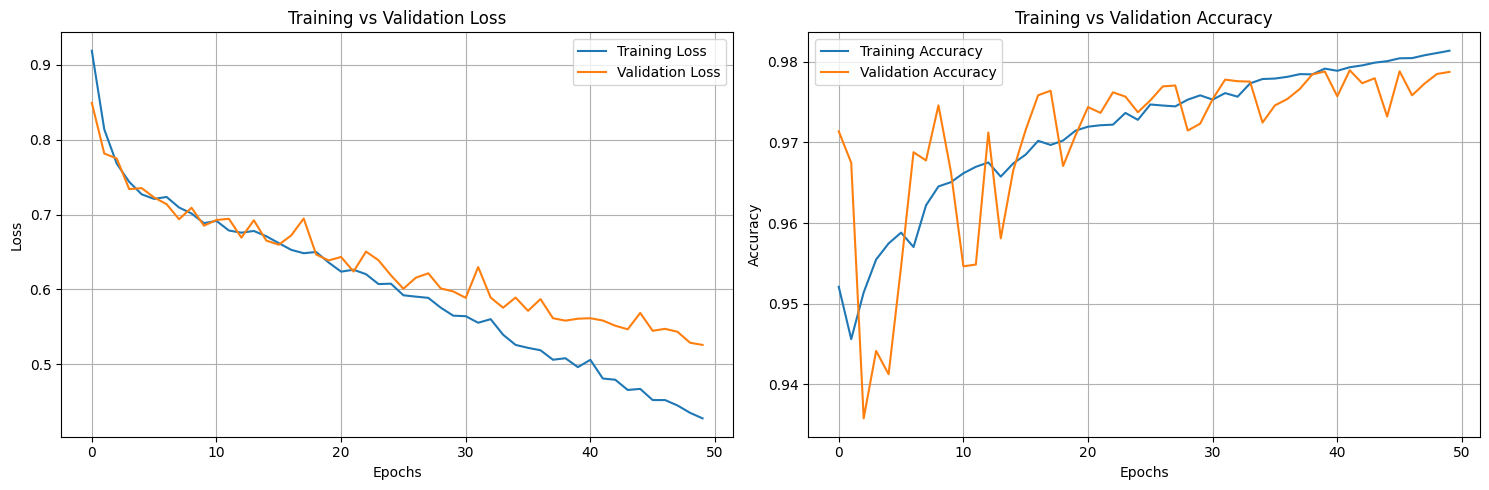

In [ ]:
plotHist(hist2_1)

We predict on the validation set and generate the metrics using the `diceScore()` and `classMets()` functions defined earlier.

In [ ]:
YValPred = model2_1.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step


In [ ]:
DICE2_1 = diceScore(YValCat, YValPred, modelName="2.1 Deeper CNN")
metrics2_1 = classMets(YValCat, YValPred, modelName="2.1 Deeper CNN")

Before displaying the results, we manually create a dataframe of the best performing model from Phase 1 which allows us to compare the results from Phase 2 against those of the baseline model. Then we concatenate the tables and display the first tally.

In [ ]:
metricsPhase1 = pd.DataFrame({
    "Macro Precision": [0.5448],
    "Macro Recall": [0.2926],
    "Macro F1": [0.3761],
    "Accuracy (No Background)": [0.3528]}, index=["1 DICE Baseline"])

dicePhase1 = pd.DataFrame({
    "Mean": [0.3026],
    "1 Necrotic Core": [0.2802],
    "2 Edema": [0.4039],
    "3 Enhancing Tumour": [0.2237]}, index=["1 DICE Baseline"])

The model demonstrates significant performance gains compared to the baseline model. The macro F1 Score has increased from 0.38 to 0.51. Recall has also improved to 0.43 from 0.29, indicating the model is able to classify a greater number of tumour pixels. Accuracy on foreground segments has improved by 10 percentage points. The mean DICE score increased from 0.3 to 0.44. The distribution of the DICE scores has also improved. While the model was previously much stronger at predicting edema segments, its ability to discriminate amongst the different tumour regions has improved. We will continue with the deeper model in the next round, gradually increasing model complexity.

In [ ]:
DICEtally = pd.concat([dicePhase1, DICE2_1])
METtally = pd.concat([metricsPhase1, metrics2_1])

In [ ]:
METtally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
1 DICE Baseline,0.5448,0.2926,0.3761,0.3528
2.1 Deeper CNN,0.6200,0.4329,0.5089,0.4557


In [ ]:
DICEtally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
1 DICE Baseline,0.3026,0.2802,0.4039,0.2237
2.1 Deeper CNN,0.4486,0.4473,0.5007,0.3979


----
----
# 2.2. BatchNorm and SpatialDropout2D
----

We test whether introducing batch normalisation and spatial dropout improves the model in this round.

Batch normalisation stabilises training by normalising the feature maps between layers. This standardises the inputs to each layer to have zero mean and unit variance, improving stability during training. It helps control the scale of the activations, which makes the network less sensitive to large gradients and introduces noise during training, which has a regularising effect. The process sets the standard deviation of the batch to one and the mean to zero after each convolutional layer by subtracting the batch mean from each input activation and dividing this value by the standard deviation:

$$
\hat{x}_i = \frac{x_i - \mu_b}{\sqrt{\sigma^2_b}}
$$

Where $x_i$ is the input activation after passing through a convolutional layer, $\mu_b$ is the batch mean and $\sqrt\sigma^2_b$ is the batch standard deviation. Batch normalisation is applied before the activation function is applied. To do this, the ReLU activation function is no longer applied as an argument within the convolutional layer but as a separate layer after the batch normalisation layer.

Spatial dropout is a dropout variant used for image-based models. Instead of dropping individual parameters, feature maps are randomly dropped during training. It is applied to the encoder layers. This stabilises training and can help with generalisation.



---
## Define & Compile Model
---

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
# Encoder
x = layers.Conv2D(32, 3, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)
# Bottleneck
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
# Decoder
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
# Output
outputs = layers.Conv2D(4, 1, activation='softmax')(x)
model_2_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile
model_2_2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=lambda yTrue, yPred: combinedLoss(yTrue, yPred, alpha=0.9), metrics=["accuracy"])

In [ ]:
model_2_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_6             │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 32, 32, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 778,660 (2.97 MB)

 Trainable params: 777,252 (2.96 MB)

 Non-trainable params: 1,408 (5.50 KB)

---
## Train Model
---

We create the model checkpoint path, the standard callbacks and fit the model with the standard training parameters for Phase 2.

In [ ]:
checkpointPath_2_2 = "saved_models_phase2/2.2_batchnorm_dropout.weights.h5"

In [ ]:
checkpoint_2_2 = ModelCheckpoint(filepath=checkpointPath_2_2,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopping_2_2 = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

In [ ]:
hist2_2 = model_2_2.fit(
    x=XTrain,
    y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint_2_2, earlyStopping_2_2],
    verbose=0)

---
## Evaluation
---

The model shows a gradual decrease and starts to plateau as the number of epochs increases. Although the validation loss is greater than the training loss, the model is not yet overfitting. Similarly, accuracy shows a strong performance of close to 100%.

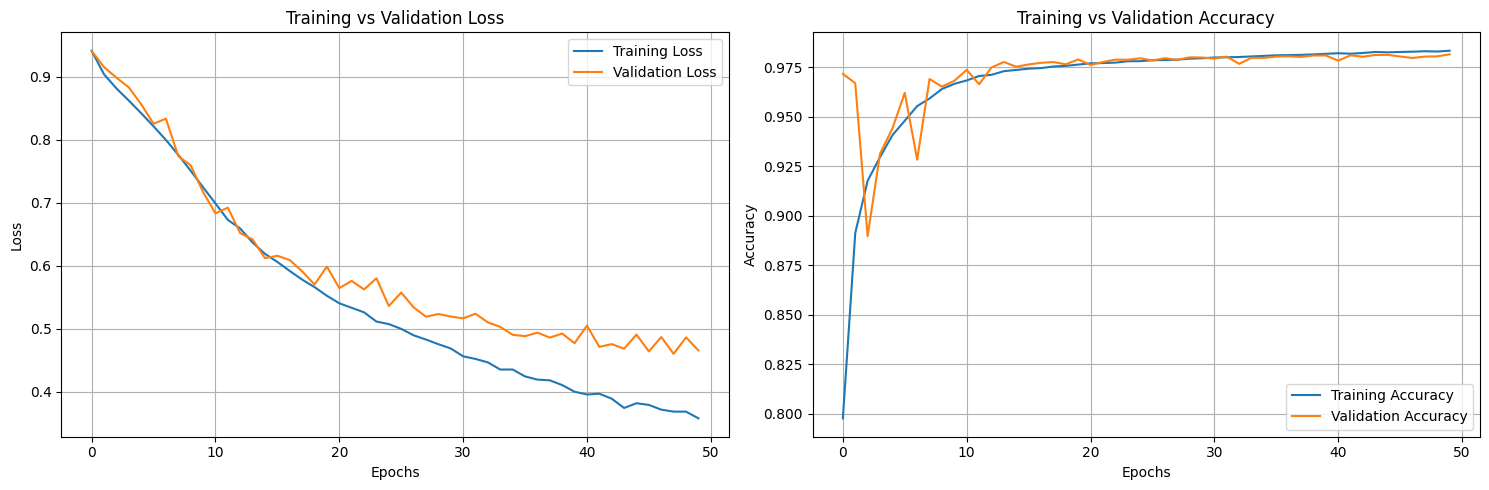

In [ ]:
plotHist(hist2_2)

We use the best performing model to make predictions on the validation set, calculate the metrics, concatenate and display the results.

In [ ]:
YValPred_2_2 = model_2_2.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


In [ ]:
DICE2_2 = diceScore(YValCat, YValPred_2_2, modelName="2.2 BatchNorm+Dropout")

In [ ]:
# Generate Classification Metrics
metrics2_2 = classMets(YValCat, YValPred_2_2, modelName="2.2 BatchNorm+Dropout")

In [ ]:
# Append to Tallies
DICEtally = pd.concat([DICEtally, DICE2_2])
METtally = pd.concat([METtally, metrics2_2])

The adjustments have improved performance. The average DICE score has increased from 0.44 to 0.52, and the results across the classes are significantly closer in range compared to previous models, suggesting the model improved its ability to distinguish between different classes. The macro accuracy metrics have improved with an F1 Score of 0.58 and a foreground accuracy of 0.53. The batch normalisation and spatial dropout components will be carried through to the next round.

In [ ]:
DICEtally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
1 DICE Baseline,0.3026,0.2802,0.4039,0.2237
2.1 Deeper CNN,0.4486,0.4473,0.5007,0.3979
2.2 BatchNorm+Dropout,0.5206,0.5346,0.5499,0.4773


In [ ]:
METtally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
1 DICE Baseline,0.5448,0.2926,0.3761,0.3528
2.1 Deeper CNN,0.6200,0.4329,0.5089,0.4557
2.2 BatchNorm+Dropout,0.6866,0.5088,0.5842,0.5314


----
----
# 2.3. Depthwise Separable Convolutions
----

Our input is shape (128, 128, 3), meaning it consists of three 128 x 128 stacked MRI modalities, FLAIR, T1CE and T2. These modalities are each a different channel in the CNN.

In a standard convolutional layer, each filter operates across all input channels simultaneously, using a 3D tensor. However, depthwise separable convolutions operate on each channel individually using a 2D tensor before a 1x1 convolution is applied to combine the information across the channels back into a single result. This allows the model to learn different feature maps for each channel individually, as it splits spatial and channel processing.

This process significantly reduces the number of parameters within the model, often at a comparable or improved performance rate.

---
## Define & Compile Model
---

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
# Encoder
x = layers.SeparableConv2D(32, 3, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)

x = layers.SeparableConv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)

x = layers.SeparableConv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)
# Bottleneck
x = layers.SeparableConv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
# Decoder
x = layers.UpSampling2D()(x)
x = layers.SeparableConv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D()(x)
x = layers.SeparableConv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D()(x)
x = layers.SeparableConv2D(32, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
# Output
outputs = layers.Conv2D(4, 1, activation='softmax')(x)
model_2_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_2_3.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=lambda yTrue, yPred: combinedLoss(yTrue, yPred, alpha=0.9), metrics=["accuracy"])

The model contains 94,431 which is 12% of the parameters used in the previous model which contained 777,252 trainable parameters.

In [ ]:
model_2_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 128, 128, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_9             │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_10            │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_11            │ (None, 32, 32, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 16, 16, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 95,839 (374.37 KB)

 Trainable params: 94,431 (368.87 KB)

 Non-trainable params: 1,408 (5.50 KB)

---
## Train Model
---

We create the model checkpoint path, the standard callbacks and fit the model with the standard training parameters for Phase 2.

In [ ]:
checkpointPath_2_3 = "saved_models_phase2/2.3_depthwise.weights.h5"

In [ ]:
checkpoint_2_3 = ModelCheckpoint(filepath=checkpointPath_2_3,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopping_2_3 = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

In [ ]:
hist2_3 = model_2_3.fit(x=XTrain,
    y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint_2_3, earlyStopping_2_3],
    verbose=0)

---
## Evaluation
---

The model shows a much smoother training loss than the previous model with the validation and training loss travelling close together at a steady rate.

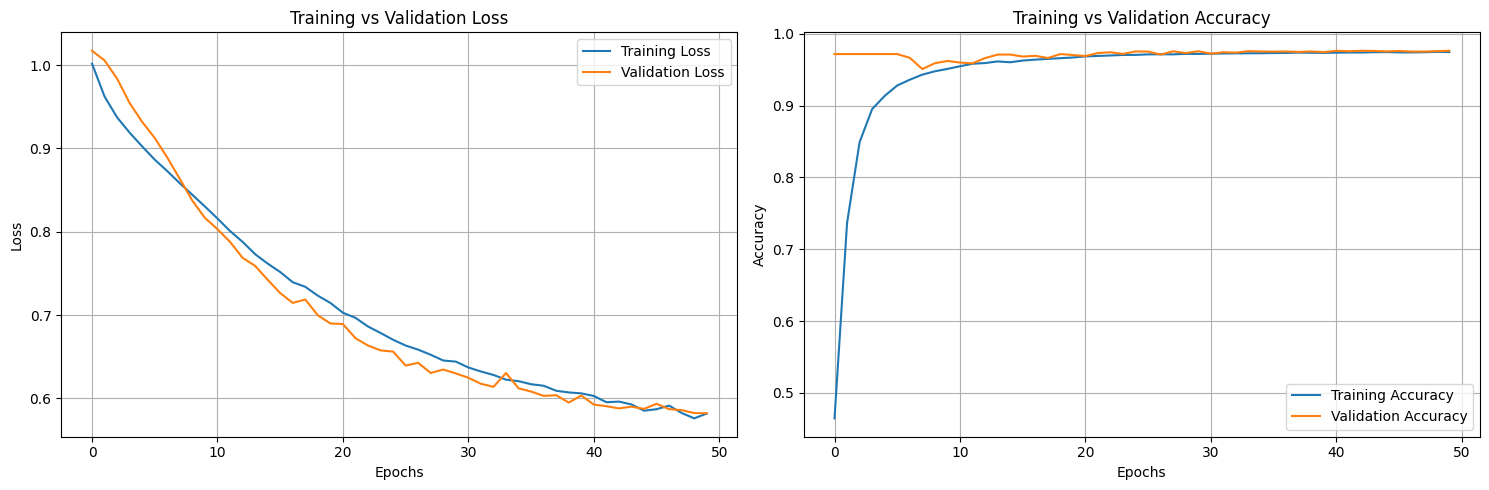

In [ ]:
plotHist(hist2_3)

### Predictions & Metrics

Generate predictions and metrics.

In [ ]:
YValPred_2_3 = model_2_3.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step


In [ ]:
DICE2_3 = diceScore(YValCat, YValPred_2_3, modelName="2.3 Depthwise CNN")

In [ ]:
metrics2_3 = classMets(YValCat, YValPred_2_3, modelName="2.3 Depthwise CNN")

In [ ]:
DICEtally = pd.concat([DICEtally, DICE2_3])
METtally = pd.concat([METtally, metrics2_3])

The model's performance dropped significantly when depthwise convolutions were included in the model with a reduction in the mean DICE score from 0.52 to 0.38 and a reduction in the macro F1 Score from 0.58 to 0.43 and foreground accuracy from 0.53 to 0.38. Therefore this architecture will not be included in the next round.

In [ ]:
DICEtally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
1 DICE Baseline,0.3026,0.2802,0.4039,0.2237
2.1 Deeper CNN,0.4486,0.4473,0.5007,0.3979
2.2 BatchNorm+Dropout,0.5206,0.5346,0.5499,0.4773
2.3 Depthwise CNN,0.3787,0.3519,0.4467,0.3374


In [ ]:
METtally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
1 DICE Baseline,0.5448,0.2926,0.3761,0.3528
2.1 Deeper CNN,0.6200,0.4329,0.5089,0.4557
2.2 BatchNorm+Dropout,0.6866,0.5088,0.5842,0.5314
2.3 Depthwise CNN,0.5629,0.3513,0.4323,0.3802


----
----
# 2.4. U-Net Architecture
----

The U-Net architecture was originally developed to segment biomedical images. During the encoding process, fine-grained spatial information can be lost as the feature maps are downsampled. The U-Net architecture adds skip connections between the encoder and decoder. This preserves spatial information from early layers by passing the information directly to the decoder layers. It helps retain details such as edge and boundary information. The decoder receives feature information from the signals processed through the model layers and local information through the skip connections. This process is visualised below.

<center>
  <figure>
    <img src="https://i.imgur.com/QPQlSPi.png" >
   </figcaption>
  </figure>
</center>

Holbrook et. al 2020 *MRI-Based Deep Learning Segmentation and Radiomics of Sarcoma in Mice*. [Source](file:///Users/augustalina/Desktop/Poster%20Images/Convolutional%20Neural%20Network%20(CNN)%20architecture%20used%20for%20segmentation....%20_%20Download%20Scientific%20Diagram.html)




---
## Define & Compile Model
---

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
# Encoder
c1 = layers.Conv2D(32, 3, padding='same')(inputs)
c1 = layers.BatchNormalization()(c1)
c1 = layers.ReLU()(c1)
c1 = layers.SpatialDropout2D(0.1)(c1)
p1 = layers.MaxPooling2D()(c1)

c2 = layers.Conv2D(64, 3, padding='same')(p1)
c2 = layers.BatchNormalization()(c2)
c2 = layers.ReLU()(c2)
c2 = layers.SpatialDropout2D(0.1)(c2)
p2 = layers.MaxPooling2D()(c2)

c3 = layers.Conv2D(128, 3, padding='same')(p2)
c3 = layers.BatchNormalization()(c3)
c3 = layers.ReLU()(c3)
c3 = layers.SpatialDropout2D(0.1)(c3)
p3 = layers.MaxPooling2D()(c3)
# Bottleneck
b = layers.Conv2D(256, 3, padding='same')(p3)
b = layers.BatchNormalization()(b)
b = layers.ReLU()(b)
# Decoder
u3 = layers.UpSampling2D()(b)
u3 = layers.Concatenate()([u3, c3])
u3 = layers.Conv2D(128, 3, padding='same')(u3)
u3 = layers.BatchNormalization()(u3)
u3 = layers.ReLU()(u3)

u2 = layers.UpSampling2D()(u3)
u2 = layers.Concatenate()([u2, c2])
u2 = layers.Conv2D(64, 3, padding='same')(u2)
u2 = layers.BatchNormalization()(u2)
u2 = layers.ReLU()(u2)

u1 = layers.UpSampling2D()(u2)
u1 = layers.Concatenate()([u1, c1])
u1 = layers.Conv2D(32, 3, padding='same')(u1)
u1 = layers.BatchNormalization()(u1)
u1 = layers.ReLU()(u1)

outputs = layers.Conv2D(4, 1, activation='softmax')(u1)
model_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_2_4.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=lambda yTrue, yPred: combinedLoss(yTrue, yPred, alpha=0.9),
    metrics=["accuracy"])

The model contains 970,788 parameters which is significantly greater than the original baseline of 185,636.

In [ ]:
model_2_4.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 128, 128,  │          0 │ re_lu_28[0][0]    │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 64, 64,    │          0 │ re_lu_29[0][0]    │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 32, 32,    │          0 │ re_lu_30[0][0]    │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 16, 16,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_17

 Total params: 972,196 (3.71 MB)

 Trainable params: 970,788 (3.70 MB)

 Non-trainable params: 1,408 (5.50 KB)

---
## Train Model
---

We create the model checkpoint path, the standard callbacks and fit the model with the standard training parameters for Phase 2.

In [ ]:
checkpointPath_2_4 = "saved_models_phase2/2.4_full_unet.weights.h5"

In [ ]:
checkpoint_2_4 = ModelCheckpoint(filepath=checkpointPath_2_4,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopping_2_4 = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

In [ ]:
hist2_4 = model_2_4.fit(x=XTrain,
    y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint_2_4, earlyStopping_2_4],
    verbose=0)

---
## Evaluation
---

The loss curves are smooth and steadily declining, with a small gap between the training and validation curves. This suggests the model is converging well and is currently underfitting the data.

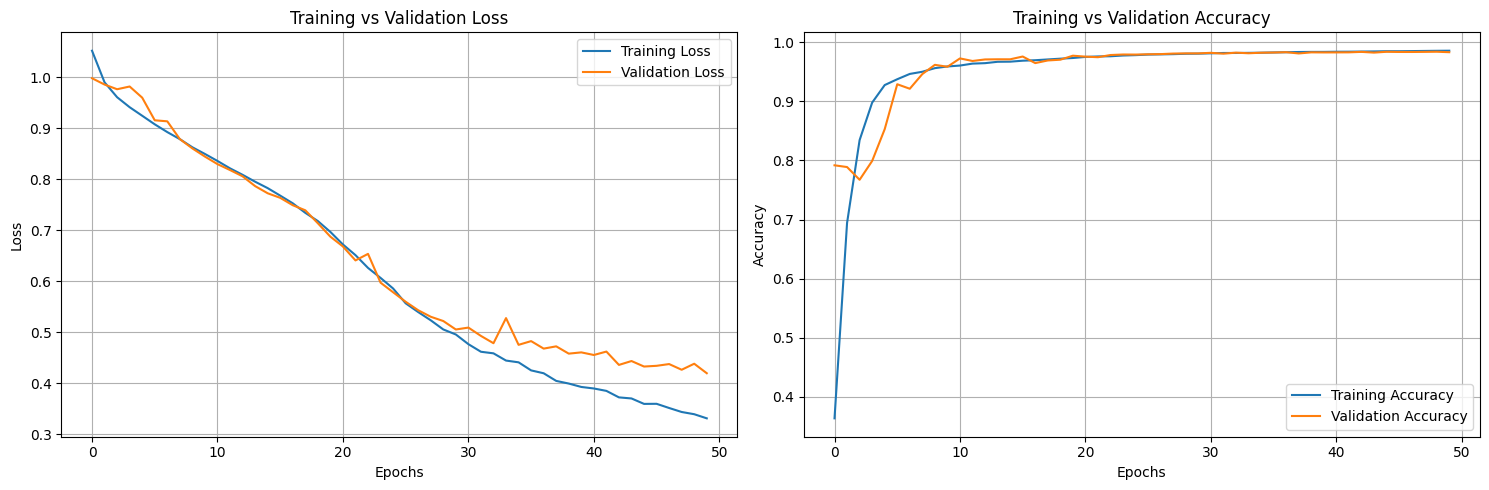

In [ ]:
plotHist(hist2_4)

### Predictions & Metrics

Generate predictions and metrics.

In [ ]:
YValPred_2_4 = model_2_4.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


In [ ]:
DICE2_4 = diceScore(YValCat, YValPred_2_4, modelName="2.4 Full U-Net")

In [ ]:
metrics2_4 = classMets(YValCat, YValPred_2_4, modelName="2.4 Full U-Net")

In [ ]:
DICEtally = pd.concat([DICEtally, DICE2_4])
METtally = pd.concat([METtally, metrics2_4])

Overall adding skip connections to model 2.2 to create a full U-Net model has significantly improved the model's performance. The average DICE score has increased to 0.56 while the F1 Score is 0.63 and the foreground accuracy is 0.57.

In [ ]:
METtally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
1 DICE Baseline,0.5448,0.2926,0.3761,0.3528
2.1 Deeper CNN,0.6200,0.4329,0.5089,0.4557
2.2 BatchNorm+Dropout,0.6866,0.5088,0.5842,0.5314
2.3 Depthwise CNN,0.5629,0.3513,0.4323,0.3802
2.4 Full U-Net,0.7133,0.5648,0.6265,0.5704


In [ ]:
DICEtally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
1 DICE Baseline,0.3026,0.2802,0.4039,0.2237
2.1 Deeper CNN,0.4486,0.4473,0.5007,0.3979
2.2 BatchNorm+Dropout,0.5206,0.5346,0.5499,0.4773
2.3 Depthwise CNN,0.3787,0.3519,0.4467,0.3374
2.4 Full U-Net,0.5637,0.5585,0.6001,0.5325


### Plot Results


We create two side-by-side bar plots to better visualise the results. The plots show that the model's performance improves as the complexity increases, with the exception of the depthwise separable convolutions. By comparing the U-Net model against the baseline model, we can see a significant improvement upon the baseline from Phase 1.

In [ ]:
metricsMeltedDice = DICEtally.reset_index().melt(
    id_vars="index",
    value_vars=["Mean", "1 Necrotic Core", "2 Edema", "3 Enhancing Tumour"],
    var_name="Metric",
    value_name="Score").rename(columns={"index": "Model"})
metricsMeltedPRA = METtally.reset_index().melt(
    id_vars="index",
    value_vars=["Macro Precision", "Macro Recall", "Macro F1", "Accuracy (No Background)"],
    var_name="Metric",
    value_name="Score").rename(columns={"index": "Model"})

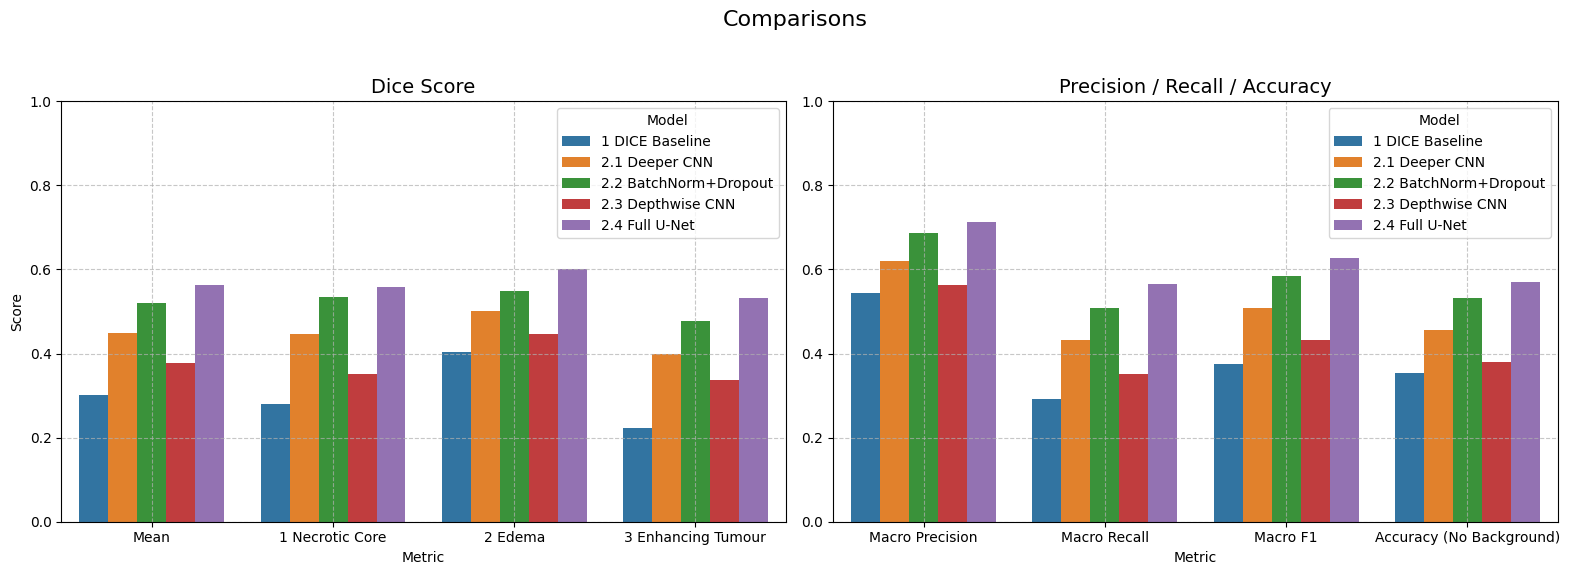

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=metricsMeltedDice, x="Metric", y="Score", hue="Model", ax=axs[0])
axs[0].set_title("Dice Score", fontsize=14)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].grid(True, linestyle='--', alpha=0.7)

sns.barplot(data=metricsMeltedPRA, x="Metric", y="Score", hue="Model", ax=axs[1])
axs[1].set_title("Precision / Recall / Accuracy", fontsize=14)
axs[1].set_ylim(0, 1)
axs[1].set_ylabel("")
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.suptitle("Comparisons", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---
---
# Conclusion
---

In Phase 2 we have increased the complexity of the model in each round. After each round, the model was evaluated on the validation set, and if the performance improved, the architectural adjustment was carried through to the next round. In Phase 2, we tested a deeper network, adding batch normalisation and spatial dropout, depthwise separable convolutions and adding skip connections to turn the CNN baseline into a U-Net model. Each additional complexity increase improved the model's performance, with the exception of the depthwise separable convolutions, which were not included in subsequent models. Next, in Phase 3, we explore unsupervised pretraining using autoencoders, we finetune the model using Keras Tuner and scale up the number of epochs before evaluating the model on the test set.

---
---